# The Crypto Detective

Richard -> Critical Mission
Needs my help (really?)

Investigating potential fraud in crypto transactions.

Richard has an anonymous dataset of Crypto X filled with transaction details that might hide secrets about financial misconduct.

Be he can't crack this puzzle alone. He's looking a skilled data scientist (then why me?)

`Challenge`: Can you dive into this dataset and help him separate legitimate transactions from suspicious ones? He believes the right analysis could protect countless investors from potential financial risks.

Challenge Accepted!

## Preprocessing and Exploratory Data Analysis

In [2]:
import pandas as pd

train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')
test_data = pd.read_csv('data/test_data.csv')

print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Unique Received From Addresses                          0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
avg val sent                                            0
total transactions (including tnx to create contract    0
total ether received                                    0
total ether balance                                     0
dtype: int64
Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
A

In [3]:
print("\nFor the Train Data:-")
print(len(train_data))
train_data.dropna(inplace=True)
print(len(train_data))

print("\nFor the Val Data:-")

print(len(val_data))
val_data.dropna(inplace=True)
print(len(val_data))

print("\nFor the Test Data:-")
print(len(test_data))
test_data.dropna(inplace=True)
print(len(test_data))


For the Train Data:-
9059
9059

For the Val Data:-
2265
2265

For the Test Data:-
2831
2831


In [4]:
# address needs to be drop because it is an identifier
train_data.drop(columns=["Address"], inplace=True)
val_data.drop(columns=["Address"], inplace=True)
test_data.drop(columns=["Address"], inplace=True)

In [5]:
# scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = train_data.drop(columns=["FLAG"])

scaled_features = scaler.fit_transform(features)

### Correlation matrix for the 12 features - excluding FLAG and Address 

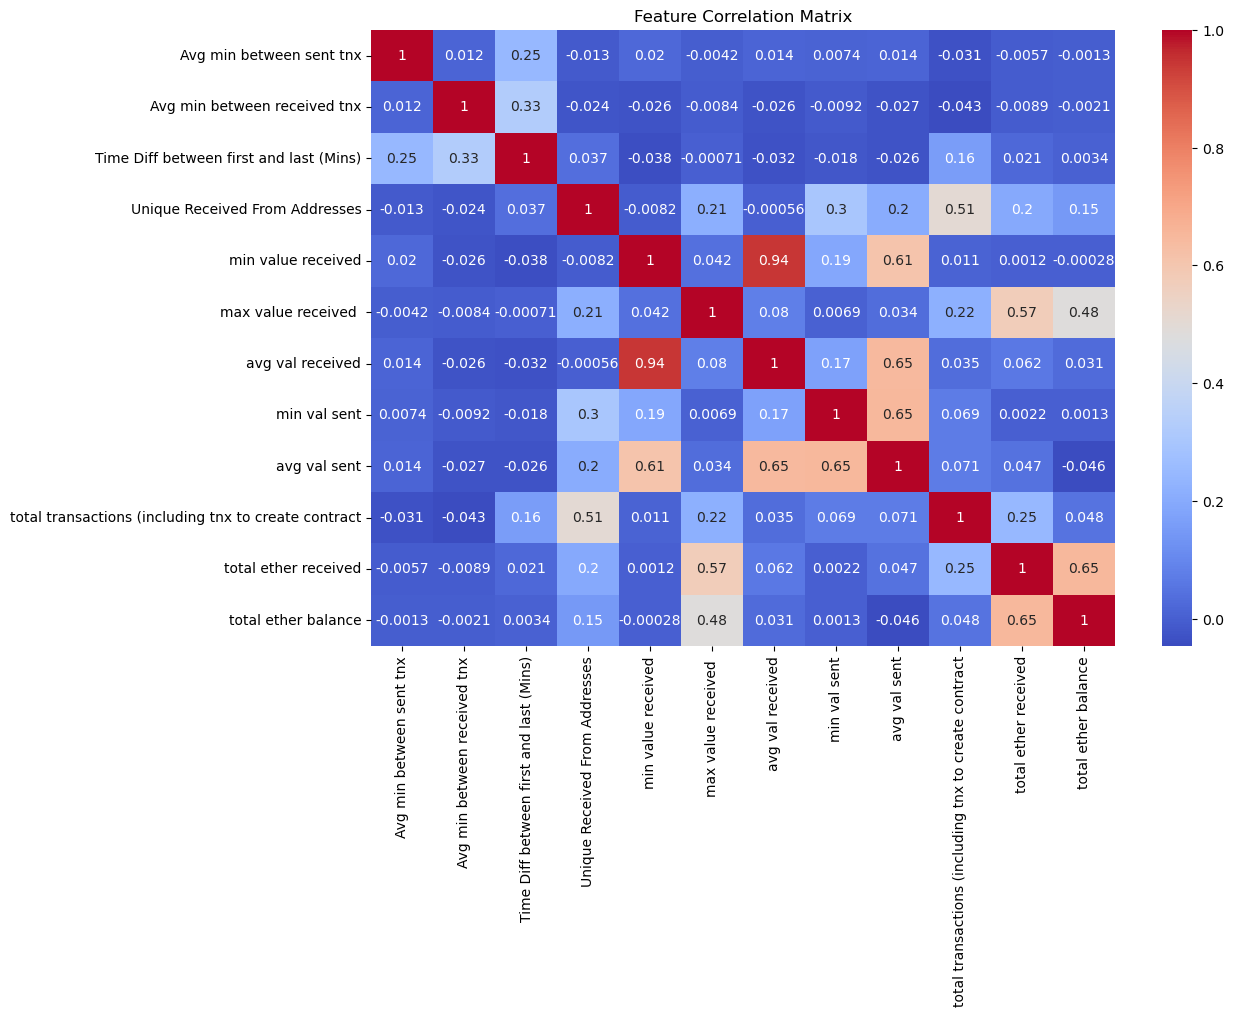

In [6]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(scaled_features, columns=features.columns).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Correlation matrix for the 13 features - excluding Address 

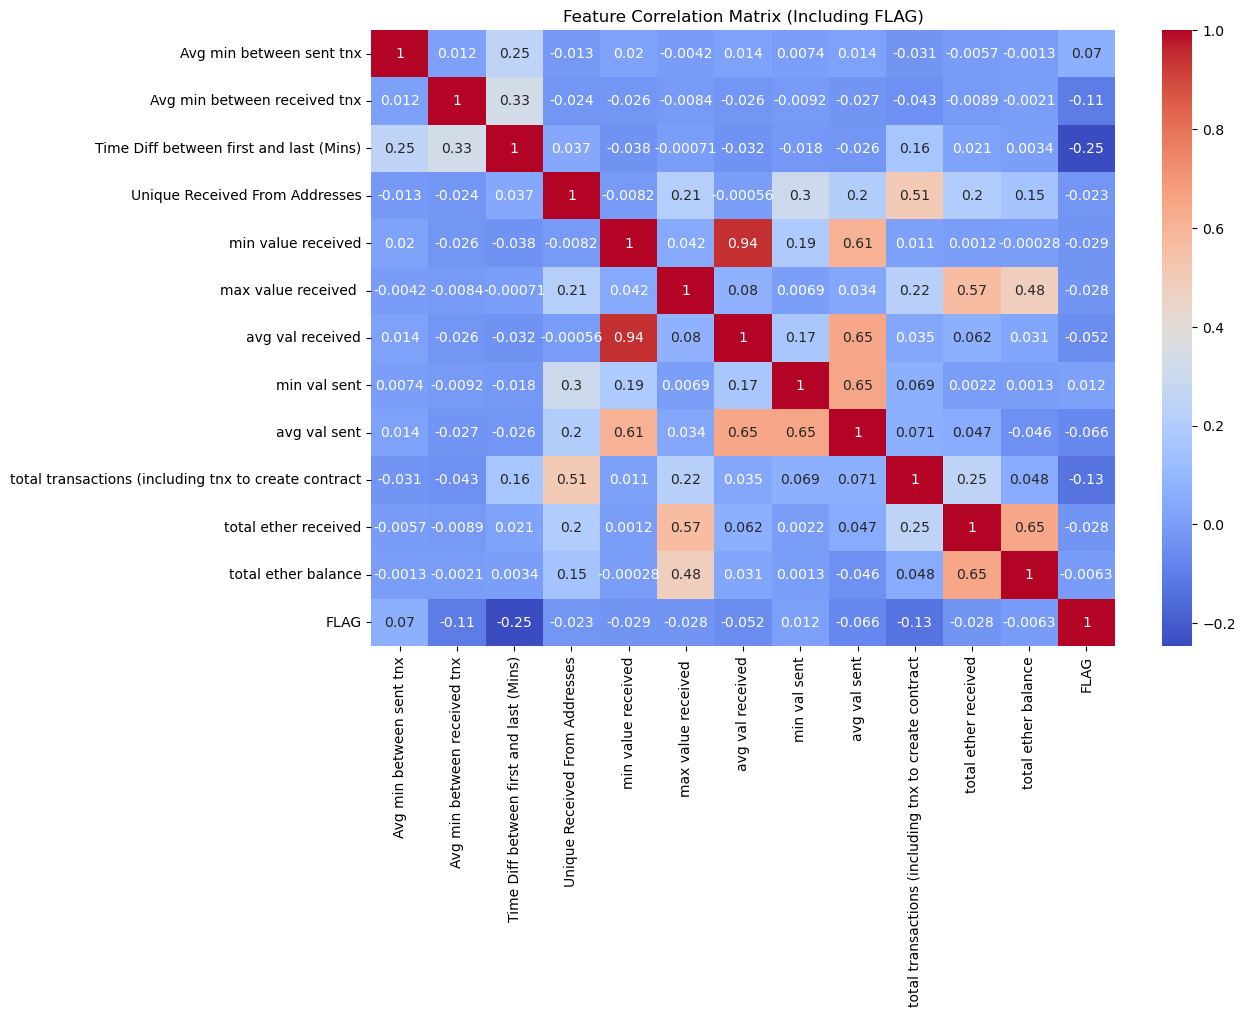

In [7]:
plt.figure(figsize=(12, 8))
corr_matrix = pd.DataFrame(scaled_features, columns=features.columns)
corr_matrix["FLAG"] = train_data["FLAG"]
sns.heatmap(corr_matrix.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix (Including FLAG)")
plt.show()

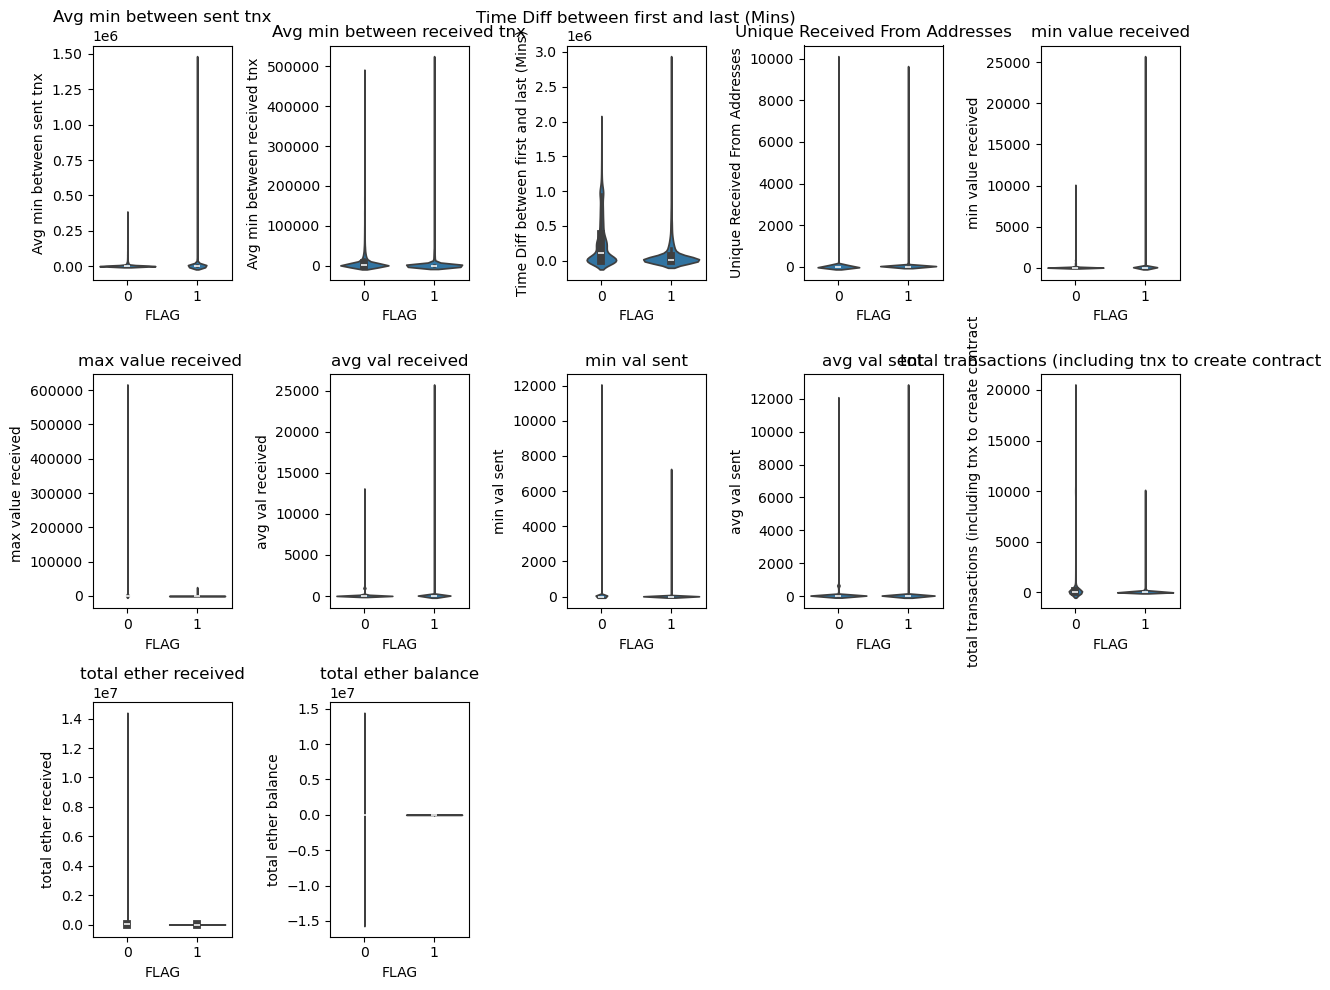

In [8]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(features.columns):
    plt.subplot(3, 5, i + 1)
    sns.violinplot(x=train_data["FLAG"], y=train_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

#### I am assuming binary split

In [21]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or len(y) < self.min_samples_split or (self.max_depth and depth >= self.max_depth):
            return np.argmax(np.bincount(y))
        
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.argmax(np.bincount(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left_subtree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {"feature": best_feature, "threshold": best_threshold, "left": left_subtree, "right": right_subtree}
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            print(feature)
            print(X[:, feature])
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue
                gain = self._information_gain(y, left_mask, right_mask)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def _information_gain(self, y, left_mask, right_mask):
        def gini(y):
            proportions = np.bincount(y) / len(y)
            return 1 - np.sum(proportions ** 2)
        
        def entropy(y):
            proportions = np.bincount(y) / len(y)
            return -np.sum([p * np.log2(p) for p in proportions if p > 0])
        
        left_size = sum(left_mask)
        right_size = sum(right_mask)
        
        if self.criterion == "gini":
            parent_impurity = gini(y)
            left_impurity = gini(y[left_mask])
            right_impurity = gini(y[right_mask])
        elif self.criterion == "entropy":
            parent_impurity = entropy(y)
            left_impurity = entropy(y[left_mask])
            right_impurity = entropy(y[right_mask])
        else:
            raise ValueError("What more criterions can you think to have?!")

        weighted_impurity = (left_size * left_impurity + right_size * right_impurity) / len(y)
        return parent_impurity - weighted_impurity

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])
    
    def _traverse_tree(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self._traverse_tree(x, node["left"])
        else:
            return self._traverse_tree(x, node["right"])

In [33]:
X_train = np.array(train_data.drop("FLAG", axis=1))
y_train = np.array(train_data["FLAG"])

X_val = np.array(val_data.drop("FLAG", axis=1))
y_val = np.array(val_data["FLAG"])

X_test = np.array(test_data.drop("FLAG", axis=1))
y_test = np.array(test_data["FLAG"])

In [34]:
print(X_train.shape)
print(y_train.shape)

(9059, 12)
(9059,)


In [36]:
import time

# change this later or the TAs might get furious
from sklearn.metrics import accuracy_score, classification_report

start_time = time.time()
custom_tree = DecisionTree(max_depth=5, min_samples_split=10)
custom_tree.fit(X_train, y_train)
preds_custom = custom_tree.predict(X_test)
custom_time = time.time() - start_time
custom_acc = accuracy_score(y_test, preds_custom)
print("Custom Decision Tree Accuracy:", custom_acc)

0
[3.33220e+02 0.00000e+00 6.18019e+03 ... 7.90000e-01 1.61500e+02
 2.78800e+01]
1
[1836.33  269.5  3503.34 ... 5058.21    0.   1213.7 ]
2
[1.5738467e+05 2.0608230e+05 5.5192428e+05 ... 2.5295020e+04 3.2300000e+02
 4.9638087e+05]
3
[66. 10. 14. ...  2.  1.  3.]
4
[1.8293008e-02 8.8038000e-02 2.1080000e-03 ... 3.3105000e-02 1.0100000e+02
 4.9956600e-01]
5
[  1.6095845   2.030283   15.        ...   0.563021  101.
   2.209982 ]
6
[  0.26471837   0.79067      3.704406   ...   0.332478   101.
   1.010539  ]
7
[0.00900743 7.905838   0.         ... 0.032265   8.999454   0.998594  ]
8
[ 0.33551325  7.905838    1.856308   ...  0.331638   50.499508
  1.033065  ]
9
[134.  11. 101. ...  10.   3. 791.]
10
[ 19.85387751   7.90669912 100.0189594  ...   1.66238821 101.
 404.2155915 ]
11
[ 5.85957210e-02  8.61000000e-04 -3.73478696e+01 ...  4.20000000e-03
  9.84218000e-04  2.87259939e-01]
0
[3.332200e+02 0.000000e+00 0.000000e+00 ... 3.081180e+04 4.137251e+04
 7.900000e-01]
1
[ 1836.33   269.5     47.6

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

start_time = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
sklearn_tree.fit(X_train, y_train)
preds_sklearn = sklearn_tree.predict(X_test)
sklearn_time = time.time() - start_time
sklearn_acc = accuracy_score(y_test, preds_sklearn)
print("Scikit-Learn Decision Tree Accuracy:", sklearn_acc)

Scikit-Learn Decision Tree Accuracy: 0.8784881667255386
